### Online Transaction History

Online trasacation data is more rich and relevant than in-store purchase data as many transaction are occuring online in response to COViD-19. We will perform and EDA and predict non contractual churn risk of customers.

In [2]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns

from lifetimes.utils import *
from lifetimes import BetaGeoFitter,GammaGammaFitter
from lifetimes.plotting import plot_probability_alive_matrix, plot_frequency_recency_matrix
from lifetimes.generate_data import beta_geometric_nbd_model
import matplotlib.pyplot as plt
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases, plot_period_transactions,plot_history_alive

from lifetimes.plotting import plot_cumulative_transactions,plot_incremental_transactions

In [3]:
# Bring in data

trnsc = pd.read_csv('transactions_export_1.csv')
orders = pd.read_csv('orders_export_1.csv')

/home/daniel/anaconda3/envs/insight/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3062: DtypeWarning: Columns (53,56) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [4]:
trnsc.head()

,Order,Name,Kind,Gateway,Created At,Status,Amount,Currency,Card Type
0,2518084223139,#0620-13227,sale,paypal,2020-06-12 12:20:47 -0700,success,36.80,USD,NaN
1,2518080782499,#0620-13226,sale,authorize_net,2020-06-12 12:18:25 -0700,success,89.95,USD,visa
2,2518031433891,#0620-13225,sale,authorize_net,2020-06-12 11:51:35 -0700,success,10.50,USD,visa
3,2517958131875,#0620-13224,sale,authorize_net,2020-06-12 11:10:33 -0700,success,72.90,USD,visa
4,2517866184867,#0620-13223,sale,authorize_net,2020-06-12 10:31:55 -0700,success,119.95,USD,master


In [5]:
orders.head()

,Name,Email,Financial Status,Paid at,Fulfillment Status,Fulfilled at,Accepts Marketing,Currency,Subtotal,Shipping,...,Tax 2 Name,Tax 2 Value,Tax 3 Name,Tax 3 Value,Tax 4 Name,Tax 4 Value,Tax 5 Name,Tax 5 Value,Phone,Receipt Number
0,#0620-13232,missdomine96@gmail.com,paid,2020-06-13 10:31:07 -0700,unfulfilled,NaN,no,USD,110.00,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,#0620-13231,rreid22@comcast.net,paid,2020-06-13 06:49:15 -0700,unfulfilled,NaN,yes,USD,10.00,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,#0620-13230,penny.com12@gmail.com,paid,2020-06-12 16:47:57 -0700,unfulfilled,NaN,yes,USD,63.30,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,#0620-13230,penny.com12@gmail.com,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,#0620-13229,angelanbobby01@aol.com,paid,2020-06-12 16:43:54 -0700,unfulfilled,NaN,yes,USD,36.95,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
trnsc.shape

(16077, 9)

In [7]:
orders.shape

(14462, 72)

I may not actually need the `trnsc` data. I think all I need is contained in the `orders` data.

In [8]:
# Create a unique_id for each customer. Surprisingly it is not in the data.

Email = list(orders.Email.unique())
orders['customer_unique_id'] = orders.Email.apply(lambda x: Email.index(x))

In [9]:
orders.head(10)



,Name,Email,Financial Status,Paid at,Fulfillment Status,Fulfilled at,Accepts Marketing,Currency,Subtotal,Shipping,...,Tax 2 Value,Tax 3 Name,Tax 3 Value,Tax 4 Name,Tax 4 Value,Tax 5 Name,Tax 5 Value,Phone,Receipt Number,customer_unique_id
0,#0620-13232,missdomine96@gmail.com,paid,2020-06-13 10:31:07 -0700,unfulfilled,NaN,no,USD,110.00,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,#0620-13231,rreid22@comcast.net,paid,2020-06-13 06:49:15 -0700,unfulfilled,NaN,yes,USD,10.00,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,#0620-13230,penny.com12@gmail.com,paid,2020-06-12 16:47:57 -0700,unfulfilled,NaN,yes,USD,63.30,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
3,#0620-13230,penny.com12@gmail.com,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
4,#0620-13229,angelanbobby01@aol.com,paid,2020-06-12 16:43:54 -0700,unfulfilled,NaN,yes,USD,36.95,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
5,#0620-13228,hanksimon@hotmail.com,paid,2020-06-12 15:57:55 -0700,unfulfilled,NaN,no,USD,99.75,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4
6,#0620-13227,rkspillman@gmail.com,paid,2020-06-12 12:20:52 -0700,unfulfilled,NaN,yes,USD,36.80,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
7,#0620-13226,annejcourt@sbcglobal.net,paid,2020-06-12 12:18:29 -0700,unfulfilled,NaN,no,USD,89.95,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6
8,#0620-13225,destinyhamilton911@gmail.com,paid,2020-06-12 11:51:40 -0700,unfulfilled,NaN,no,USD,10.50,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.503348e+10,NaN,7
9,#0620-13224,kirsten.roae19@gmail.com,paid,2020-06-12 11:10:36 -0700,unfulfilled,NaN,yes,USD,72.90,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8


#### Building out the dataset

The model only requires a few variables, Let's do some feature engineering and focus only on what we really need for the RFM analysis.

In [10]:
# Distribution of purchases made by customers

orders.groupby('customer_unique_id').size().value_counts()

1      8607
2      1257
3       341
4       163
5        75
6        38
7        27
8        20
9        10
11        5
12        4
10        3
18        2
14        2
24        2
30        1
16        1
15        1
17        1
29        1
13        1
22        1
19        1
23        1
20        1
175       1
dtype: int64

In [11]:
# Order Id's have multiple entries. Keep the first line as that has price information associated with it.

orders.drop_duplicates('Name',keep='first',inplace=True)

In [12]:
orders.head()

,Name,Email,Financial Status,Paid at,Fulfillment Status,Fulfilled at,Accepts Marketing,Currency,Subtotal,Shipping,...,Tax 2 Value,Tax 3 Name,Tax 3 Value,Tax 4 Name,Tax 4 Value,Tax 5 Name,Tax 5 Value,Phone,Receipt Number,customer_unique_id
0,#0620-13232,missdomine96@gmail.com,paid,2020-06-13 10:31:07 -0700,unfulfilled,NaN,no,USD,110.00,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,#0620-13231,rreid22@comcast.net,paid,2020-06-13 06:49:15 -0700,unfulfilled,NaN,yes,USD,10.00,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,#0620-13230,penny.com12@gmail.com,paid,2020-06-12 16:47:57 -0700,unfulfilled,NaN,yes,USD,63.30,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
4,#0620-13229,angelanbobby01@aol.com,paid,2020-06-12 16:43:54 -0700,unfulfilled,NaN,yes,USD,36.95,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
5,#0620-13228,hanksimon@hotmail.com,paid,2020-06-12 15:57:55 -0700,unfulfilled,NaN,no,USD,99.75,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4


In [13]:
#orders.to_csv('order_test.csv')

Now subset the data into something more manageable and ditch the datetime stamp

In [14]:
transaction_data= orders[['customer_unique_id','Total','Created at']]

In [15]:
transaction_data.head()

,customer_unique_id,Total,Created at
0,0,110.00,2020-06-13 10:31:06 -0700
1,1,10.00,2020-06-13 06:49:14 -0700
2,2,63.30,2020-06-12 16:47:56 -0700
4,3,36.95,2020-06-12 16:43:53 -0700
5,4,99.75,2020-06-12 15:57:54 -0700


In [16]:
transaction_data.columns = transaction_data.columns.str.replace(' ', '_')

In [17]:
list(transaction_data.columns) 

['customer_unique_id', 'Total', 'Created_at']

In [18]:
type(transaction_data['Created_at'][10])

str

In [19]:
pd.to_datetime(transaction_data.Created_at.apply(lambda x: x.split()[0]))


0       2020-06-13
1       2020-06-13
2       2020-06-12
4       2020-06-12
5       2020-06-12
           ...    
14457   2014-12-08
14458   2014-12-08
14459   2014-12-06
14460   2014-12-06
14461   2014-12-06
Name: Created_at, Length: 12100, dtype: datetime64[ns]

In [20]:
#transaction_data.Paid_at[transaction_data.Paid_at.apply(lambda x:type(x)==float)]

In [21]:
transaction_data['Created_at']= pd.to_datetime(transaction_data['Created_at'], errors='coerce', utc = True).dt.date

In [22]:
transaction_data.head()

,customer_unique_id,Total,Created_at
0,0,110.00,2020-06-13
1,1,10.00,2020-06-13
2,2,63.30,2020-06-12
4,3,36.95,2020-06-12
5,4,99.75,2020-06-12


In [23]:
transaction_data['date'] = transaction_data['Created_at']
transaction_data['price'] = transaction_data['Total']
transaction_data.head()

,customer_unique_id,Total,Created_at,date,price
0,0,110.00,2020-06-13,2020-06-13,110.00
1,1,10.00,2020-06-13,2020-06-13,10.00
2,2,63.30,2020-06-12,2020-06-12,63.30
4,3,36.95,2020-06-12,2020-06-12,36.95
5,4,99.75,2020-06-12,2020-06-12,99.75


In [24]:
# Drop 'Paid_at'
transaction_data.drop(columns=['Created_at', 'Total'])

,customer_unique_id,date,price
0,0,2020-06-13,110.00
1,1,2020-06-13,10.00
2,2,2020-06-12,63.30
4,3,2020-06-12,36.95
5,4,2020-06-12,99.75
...,...,...,...
14457,10563,2014-12-08,229.90
14458,4729,2014-12-08,99.90
14459,10564,2014-12-07,79.95
14460,10565,2014-12-07,82.90


#### RFM Model

Now that the transaction data has been prepared we need to convert data to an RFM dataframe using the `lifetimes` package 

In [25]:
summary = summary_data_from_transaction_data(transaction_data,'customer_unique_id','date',monetary_value_col='price',)
summary.describe()


,frequency,recency,T,monetary_value
count,10567.000000,10567.000000,10567.000000,10567.000000
mean,0.131731,18.834958,618.200625,11.388800
std,0.858679,121.981965,541.467090,45.123276
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,218.000000,0.000000
50%,0.000000,0.000000,454.000000,0.000000
75%,0.000000,0.000000,900.000000,0.000000
max,70.000000,1895.000000,2016.000000,664.450000


In [26]:
summary.head()

,frequency,recency,T,monetary_value
customer_unique_id,,,,
0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0
3,0.0,0.0,1.0,0.0
4,0.0,0.0,1.0,0.0


In [27]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_colwidth', 400)
summary.head(100)

,frequency,recency,T,monetary_value
customer_unique_id,,,,
0,0.0,0.0,0.0,0.000
1,0.0,0.0,0.0,0.000
2,0.0,0.0,1.0,0.000
3,0.0,0.0,1.0,0.000
4,0.0,0.0,1.0,0.000
5,0.0,0.0,1.0,0.000
6,1.0,6.0,7.0,89.950
7,0.0,0.0,1.0,0.000
8,0.0,0.0,1.0,0.000


* frequency: # of days in which a customer made a repeat purchase
* T: customer's age in days
* recency: customer's age in days at time of most recent purchase
* monetary_value: mean of a customer's purchases, excluding the 1st purchase

*frequency excludes the customer's first purchase because that is considered the day the customer is born. 

In [28]:
summary[summary['frequency']>0].head()

,frequency,recency,T,monetary_value
customer_unique_id,,,,
6,1.0,6.0,7.0,89.95
14,1.0,23.0,25.0,86.13
17,1.0,3.0,5.0,456.45
23,1.0,56.0,58.0,229.95
62,1.0,10.0,14.0,119.95


#### Creating the BG/NBD Model


In [29]:
bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(summary['frequency'], summary['recency'], summary['T']);
print(bgf.fit)

<bound method BetaGeoFitter.fit of <lifetimes.BetaGeoFitter: fitted with 10567 subjects, a: 1.89, alpha: 3.82, b: 0.83, r: 0.02>>


In [30]:
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,0.019980,0.000830,0.018353,0.021606
alpha,3.824494,0.438991,2.964071,4.684916
a,1.885867,0.331649,1.235836,2.535899
b,0.827495,0.170456,0.493401,1.161589


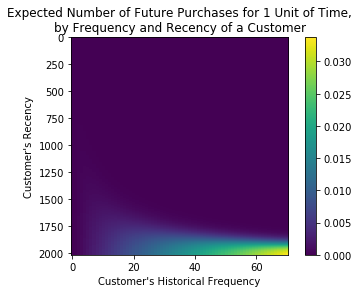

In [31]:
plot_frequency_recency_matrix(bgf);
plt.savefig('plot1.png', dpi=300, bbox_inches='tight')

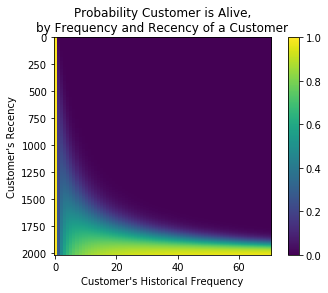

In [32]:
plot_probability_alive_matrix(bgf);
plt.savefig('plot2.png', dpi=300, bbox_inches='tight')

#### Train a BG/NBD Model

Evaluate the model to see how well it performs in the future. Split data for testing into training and observation datasets.

##### Calibration Period Histogram

How well does the model fit the training data?

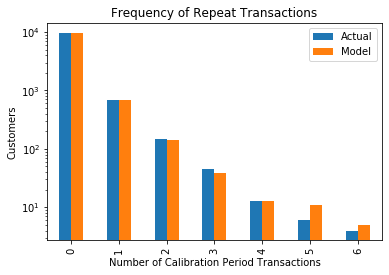

In [33]:
plot_period_transactions(bgf).set_yscale('log');
plt.savefig('plot3.png', dpi=300, bbox_inches='tight')

It looks as if the model performs well up until the 4th repeat transaction period. It does not seem that there are more than four repeat customers. Then it seems we are overfitting at that point.

##### Cumulative Transaction Plot

Plot predicted and actual cummulative transactions

In [34]:
summary_cal_holdout = calibration_and_holdout_data(transaction_data, 'customer_unique_id', 'date',calibration_period_end='2019-03-01', observation_period_end='2020-03-01' )

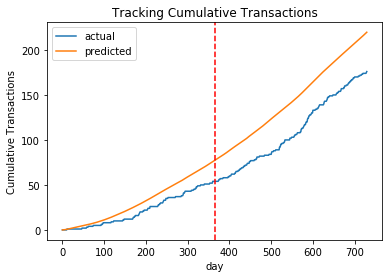

In [35]:
bgf.fit(summary_cal_holdout['frequency_cal'], summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'])
plot_cumulative_transactions(bgf, transaction_data, 'date', 'customer_unique_id', 730, 365);
plt.savefig('plot4.png', dpi=300, bbox_inches='tight')

It looks as if I'm over-fitting a bit here. Will need to look into this.

##### Incremental Transaction Plot

How well does the model capture trends in the data?

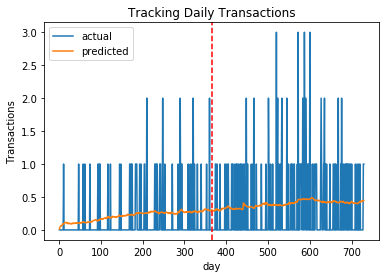

In [36]:
plot_incremental_transactions(bgf, transaction_data, 'date', 'customer_unique_id', 730, 365);
plt.savefig('plot5.png', dpi=300, bbox_inches='tight')

Doesn't really do a good job at capturing trends in the data. Will want to tune this.

##### Conditional Expectations Plot

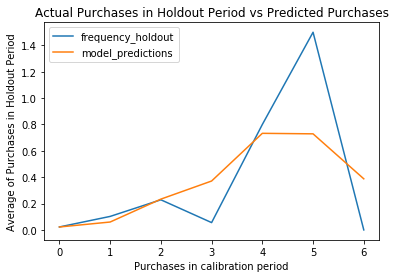

In [37]:
plot_calibration_purchases_vs_holdout_purchases(bgf, summary_cal_holdout);
plt.savefig('plot6.png', dpi=300, bbox_inches='tight')

Model seems to perform well up to 3 calibration periods of purchases, and drops off after that. Will have to hypertune this to get it better.

In [38]:
transaction_data.groupby('customer_unique_id').size().value_counts()

1     9565
2      748
3      161
4       53
5       17
8        7
7        5
6        5
9        2
19       1
11       1
10       1
80       1
dtype: int64

There are not a lot of repeat customers.
* 9% of customers made 2 or more purchases.
* 2% of customers made 3 or more purchases.
* Less than 1% of customers made 4 or more purchases.

It may very well be that customers tend to purchase once on the site and there isn't much of a signal or an old enough dataset to necessitate churn. Perhaps there are some other dimensions of  store other than products that increase retention and customer loyalty.

#### Modeling Probability of Churn

BG/NBD Model assumes that customer death can only occur after a 2nd purchase. I cannot assume that customers that have only made 1 purchase are still viable customers. I limit the analysis to customers that have made a repeat transaction.

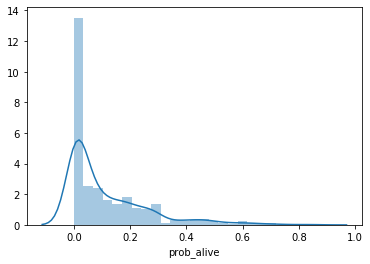

In [39]:
df = summary[summary['frequency']>0]
df['prob_alive'] = bgf.conditional_probability_alive(df['frequency'],df['recency'],df['T'])
sns.distplot(df['prob_alive']);
plt.savefig('plot7.png', dpi=300, bbox_inches='tight')

This plot gives us the probability that customers are still "alive". We need to apply a threshold for churn. This is arbitrary. Should dig into industry standards to understand if there are any general trends around customers churn in the shoe industry. Customer with less than 7% chance of being alive has churned.

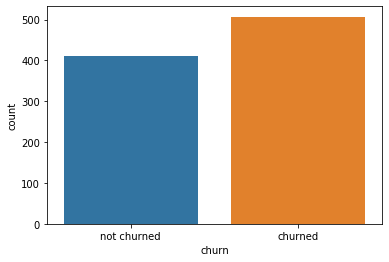

In [40]:
df['churn'] = ['churned' if p < .07 else 'not churned' for p in df['prob_alive']]
sns.countplot(df['churn']);
plt.savefig('plot8.png', dpi=300, bbox_inches='tight')

A lot of customers have churned. However a fair amount haven't. Looks like a 60/40% split.

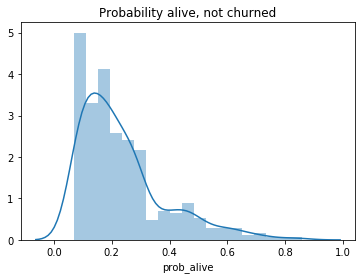

In [41]:
sns.distplot(df[df['churn']=='not churned']['prob_alive']).set_title('Probability alive, not churned');
plt.savefig('plot9.png', dpi=300, bbox_inches='tight')

Bucket customers into a bin if they have 80% or more churn risk they can be considered a "high churn risk".

In [42]:
df['churn'][(df['prob_alive']>=.1) & (df['prob_alive']<.2)] = "high risk"
df['churn'].value_counts()

churned        507
not churned    262
high risk      149
Name: churn, dtype: int64

In [42]:
df.head()

,frequency,recency,T,monetary_value,prob_alive,churn
customer_unique_id,,,,,,
6,1.0,6.0,7.0,89.95,0.280711,not churned
14,1.0,23.0,25.0,86.13,0.285264,not churned
17,1.0,3.0,5.0,456.45,0.250953,not churned
23,1.0,56.0,58.0,229.95,0.293249,not churned
62,1.0,10.0,14.0,119.95,0.250110,not churned


#### Modeling Churn using Markov Chains

In [43]:
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [44]:
summary.head()

,frequency,recency,T,monetary_value
customer_unique_id,,,,
0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0
3,0.0,0.0,1.0,0.0
4,0.0,0.0,1.0,0.0


In [45]:
rfm = summary.drop(columns=['monetary_value']) 
rfm.head()

,frequency,recency,T
customer_unique_id,,,
0,0.0,0.0,0.0
1,0.0,0.0,0.0
2,0.0,0.0,1.0
3,0.0,0.0,1.0
4,0.0,0.0,1.0
